### Binary Classification Model for Company Bankruptcy Prediction Using Python and Scikit-Learn Take 1
### David Lowe
### April 5, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Company Bankruptcy Prediction dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: The research team collected the data from the Taiwan Economic Journal from 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange. Because not catching companies in a shaky financial situation is a costly business proposition, we will maximize the precision and recall ratios with the F1 score.

The data analysis first appeared on the research paper, Liang, D., Lu, C.-C., Tsai, C.-F., and Shih, G.-A. (2016) Financial Ratios and Corporate Governance Indicators in Bankruptcy Prediction: A Comprehensive Study. European Journal of Operational Research, vol. 252, no. 2, pp. 561-572.

This Take1 iteration will construct and tune several classic machine learning models using the Scikit-Learn library. We also will observe the best results that we can obtain from the models.

ANALYSIS: The average performance of the machine learning algorithms achieved an F1 score of 94.37%. Two algorithms (Extra Trees and Random Forest) produced the top F1 metrics after the first round of modeling. After a series of tuning trials, the Extra Trees model turned in an F1 score of 97.39% using the training dataset. When we applied the Extra Tree model to the previously unseen test dataset, we obtained an F1 score of 55.55%.

CONCLUSION: In this iteration, the Random Forest model appeared to be a suitable algorithm for modeling this dataset. We should consider using the algorithm for further modeling.

Dataset Used: Company Bankruptcy Prediction Data Set

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/Taiwanese+Bankruptcy+Prediction

One potential source of performance benchmark: https://www.kaggle.com/fedesoriano/company-bankruptcy-prediction

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [301]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [302]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [303]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [304]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [305]:
# Set the random seed number for reproducible results
seedNum = 8

In [306]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import RFE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

### 1.b) Set up the controlling parameters and functions

In [307]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = False
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
scoring = 'f1'

In [308]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [309]:
if notifyStatus: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [310]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-company-bankruptcy-prediction/data_fedesoriano.csv'
attrNames = ['X' + str(i) for i in range(1,96)]
colNames = ['targetVar'] + attrNames
Xy_original = pd.read_csv(dataset_path, sep=',', index_col=False)
Xy_original.columns = colNames

# Take a peek at the dataframe after import
Xy_original.head(10)

,targetVar,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
5,1,0.388680,0.415177,0.419134,0.590171,0.590251,0.998758,0.796903,0.808771,0.303116,...,0.710420,0.005278,0.622605,0.590172,0.829939,0.285087,0.026675,0.564538,1,0.019534
6,0,0.390923,0.445704,0.436158,0.619950,0.619950,0.998993,0.797012,0.808960,0.302814,...,0.736619,0.018372,0.623655,0.619949,0.829980,0.292504,0.026622,0.564200,1,0.015663
7,0,0.508361,0.570922,0.559077,0.601738,0.601717,0.999009,0.797449,0.809362,0.303545,...,0.815350,0.010005,0.623843,0.601739,0.841459,0.278607,0.027031,0.566089,1,0.034889
8,0,0.488519,0.545137,0.543284,0.603612,0.603612,0.998961,0.797414,0.809338,0.303584,...,0.803647,0.000824,0.623977,0.603613,0.840487,0.276423,0.026891,0.565592,1,0.065826
9,0,0.495686,0.550916,0.542963,0.599209,0.599209,0.999001,0.797404,0.809320,0.303483,...,0.804195,0.005798,0.623865,0.599205,0.840688,0.279388,0.027243,0.566668,1,0.030801


In [311]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   targetVar  6819 non-null   int64  
 1   X1         6819 non-null   float64
 2   X2         6819 non-null   float64
 3   X3         6819 non-null   float64
 4   X4         6819 non-null   float64
 5   X5         6819 non-null   float64
 6   X6         6819 non-null   float64
 7   X7         6819 non-null   float64
 8   X8         6819 non-null   float64
 9   X9         6819 non-null   float64
 10  X10        6819 non-null   float64
 11  X11        6819 non-null   float64
 12  X12        6819 non-null   float64
 13  X13        6819 non-null   float64
 14  X14        6819 non-null   float64
 15  X15        6819 non-null   float64
 16  X16        6819 non-null   float64
 17  X17        6819 non-null   float64
 18  X18        6819 non-null   float64
 19  X19        6819 non-null   float64
 20  X20     

In [312]:
Xy_original.describe()

,targetVar,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [313]:
Xy_original.isnull().sum()

targetVar    0
X1           0
X2           0
X3           0
X4           0
X5           0
X6           0
X7           0
X8           0
X9           0
X10          0
X11          0
X12          0
X13          0
X14          0
X15          0
X16          0
X17          0
X18          0
X19          0
X20          0
X21          0
X22          0
X23          0
X24          0
X25          0
X26          0
X27          0
X28          0
X29          0
X30          0
X31          0
X32          0
X33          0
X34          0
X35          0
X36          0
X37          0
X38          0
X39          0
X40          0
X41          0
X42          0
X43          0
X44          0
X45          0
X46          0
X47          0
X48          0
X49          0
X50          0
X51          0
X52          0
X53          0
X54          0
X55          0
X56          0
X57          0
X58          0
X59          0
X60          0
X61          0
X62          0
X63          0
X64          0
X65          0
X66       

In [314]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [315]:
# Dropping features
Xy_original.drop(columns=['X94'], inplace=True)

# Take a peek at the dataframe after cleaning
Xy_original.head()

,targetVar,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X85,X86,X87,X88,X89,X90,X91,X92,X93,X95
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490


### 1.e) Splitting Data into Training and Test Sets

In [316]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = 1

In [317]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (6819, 95) X_original.shape: (6819, 94) y_original.shape: (6819,)


In [318]:
# Split the data further into training, validation, and test datasets
# X_train_val, X_test_df, y_train_val, y_test_df = train_test_split(X_original, y_original, test_size=test_set_size, stratify=y_original, random_state=seedNum)
# X_train_df, X_validation_df, y_train_df, y_validation_df = train_test_split(X_train_val, y_train_val, test_size=val_set_size, stratify=y_train_val, random_state=seedNum)
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=test_set_size, stratify=y_original, random_state=seedNum)
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
# print("X_validation_df.shape: {} y_validation_df.shape: {}".format(X_validation_df.shape, y_validation_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (5455, 94) y_train_df.shape: (5455,)
X_test_df.shape: (1364, 94) y_test_df.shape: (1364,)


### 1.f) Set up the parameters for data visualization

In [319]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [320]:
if notifyStatus: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [321]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [322]:
X_train_df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X85,X86,X87,X88,X89,X90,X91,X92,X93,X95
5257,0.487788,0.560783,0.543230,0.600290,0.600290,0.998680,0.798059,0.809965,0.305298,0.782274,...,0,0.814199,0.000819,0.623842,0.600288,0.840908,0.274917,0.026796,0.565183,0.420566
5962,0.486423,0.575392,0.531827,0.611367,0.611640,0.999037,0.797523,0.809417,0.303614,0.781601,...,0,0.824192,0.000511,0.624078,0.611366,0.841613,0.276094,0.026816,0.565274,0.078773
4565,0.580315,0.617368,0.647626,0.611835,0.611835,0.999181,0.797632,0.809554,0.303504,0.781831,...,0,0.841289,0.003119,0.623445,0.611830,0.842964,0.277358,0.026828,0.565330,0.046390
3677,0.614245,0.645824,0.684780,0.627567,0.627567,0.999348,0.797874,0.809786,0.303578,0.782062,...,0,0.857660,0.001251,0.623026,0.627562,0.843096,0.275203,0.026791,0.565159,0.195811
6418,0.513041,0.573866,0.557846,0.606098,0.606098,0.999057,0.797506,0.809397,0.303543,0.781659,...,0,0.820336,0.007022,0.624163,0.606095,0.841909,0.279109,0.026881,0.565552,0.032097


#### 2.a.ii) Dimensions and attribute types

In [323]:
X_train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5455 entries, 5257 to 6745
Data columns (total 94 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      5455 non-null   float64
 1   X2      5455 non-null   float64
 2   X3      5455 non-null   float64
 3   X4      5455 non-null   float64
 4   X5      5455 non-null   float64
 5   X6      5455 non-null   float64
 6   X7      5455 non-null   float64
 7   X8      5455 non-null   float64
 8   X9      5455 non-null   float64
 9   X10     5455 non-null   float64
 10  X11     5455 non-null   float64
 11  X12     5455 non-null   float64
 12  X13     5455 non-null   float64
 13  X14     5455 non-null   float64
 14  X15     5455 non-null   float64
 15  X16     5455 non-null   float64
 16  X17     5455 non-null   float64
 17  X18     5455 non-null   float64
 18  X19     5455 non-null   float64
 19  X20     5455 non-null   float64
 20  X21     5455 non-null   float64
 21  X22     5455 non-null   float64
 2

#### 2.a.iii) Statistical summary of the attributes

In [324]:
X_train_df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X85,X86,X87,X88,X89,X90,X91,X92,X93,X95
count,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,...,5455.00000,5455.000000,5.455000e+03,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000
mean,0.505098,0.558545,0.553636,0.607950,0.607936,0.998713,0.797162,0.809050,0.303661,0.781341,...,0.00110,0.807795,1.251769e+07,0.624034,0.607948,0.840317,0.280476,0.027618,0.565350,0.047604
std,0.059905,0.064981,0.060433,0.015806,0.015793,0.014528,0.014143,0.014992,0.011876,0.014113,...,0.03315,0.038931,2.963650e+08,0.010486,0.015806,0.015864,0.015800,0.016875,0.014551,0.051788
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.224792,1.015558e-04,0.408682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.476210,0.535543,0.527170,0.600383,0.600380,0.998969,0.797386,0.809312,0.303464,0.781567,...,0.00000,0.796735,8.875174e-04,0.623637,0.600382,0.840113,0.276968,0.026791,0.565158,0.024357
50%,0.502462,0.559693,0.552117,0.605925,0.605904,0.999022,0.797463,0.809375,0.303525,0.781634,...,0.00000,0.810419,2.067312e-03,0.623881,0.605927,0.841160,0.278779,0.026808,0.565252,0.033798
75%,0.535173,0.588721,0.583650,0.613997,0.613961,0.999095,0.797578,0.809468,0.303584,0.781734,...,0.00000,0.826414,5.290921e-03,0.624168,0.613995,0.842334,0.281524,0.026914,0.565731,0.052481
max,1.000000,1.000000,1.000000,0.665151,0.666023,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,9.650000e+09,1.000000,0.665149,0.996912,1.000000,1.000000,1.000000,1.000000


#### 2.a.iv) Summarize the levels of the class attribute

In [325]:
y_train_df.groupby(y_train_df).size()

targetVar
0    5279
1     176
Name: targetVar, dtype: int64

### 2.b) Data Visualization

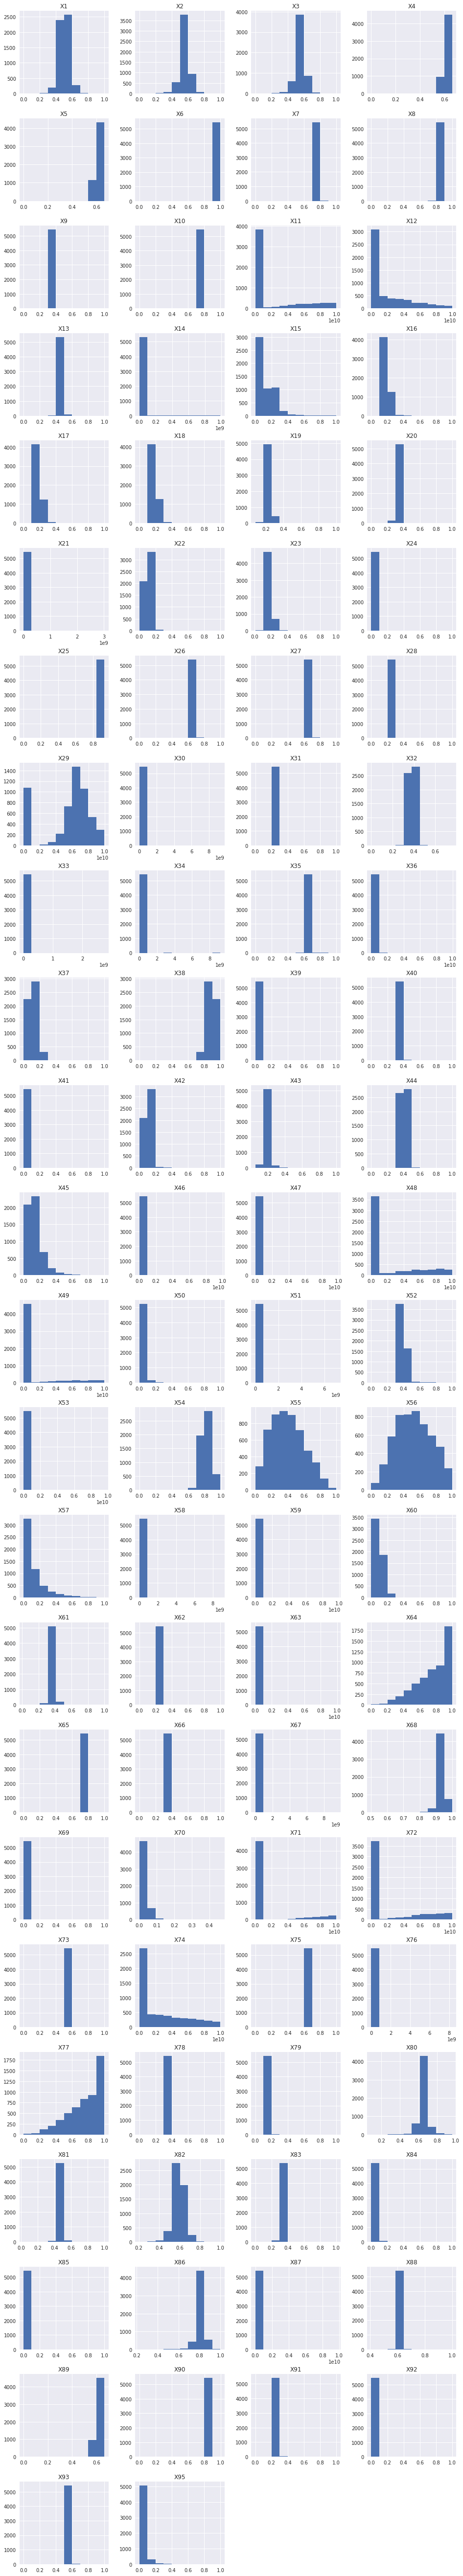

In [326]:
# Histograms for each attribute
X_train_df.hist(layout=(dispRow,dispCol))
plt.show()

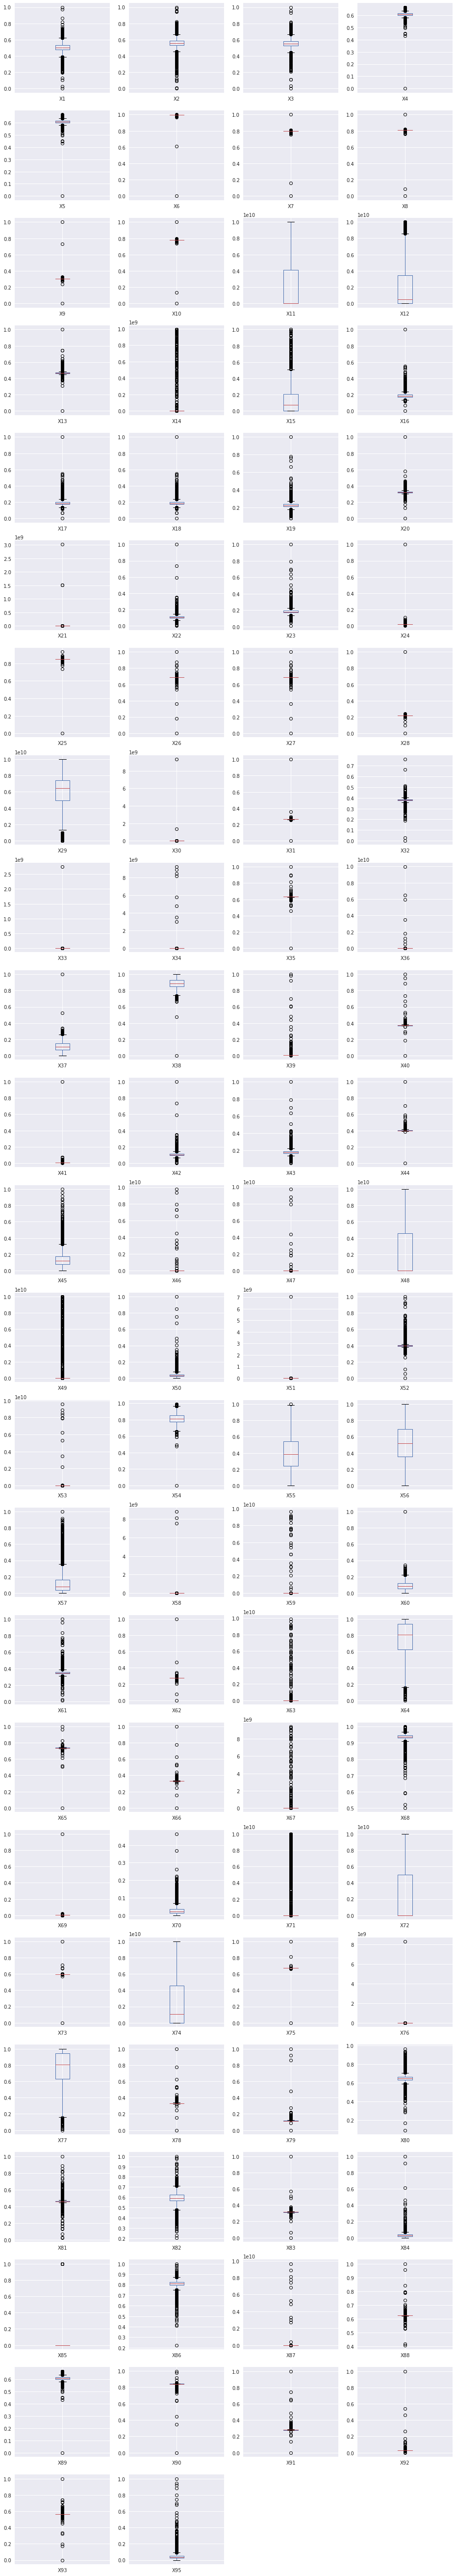

In [327]:
# Box and Whisker plot for each attribute
X_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

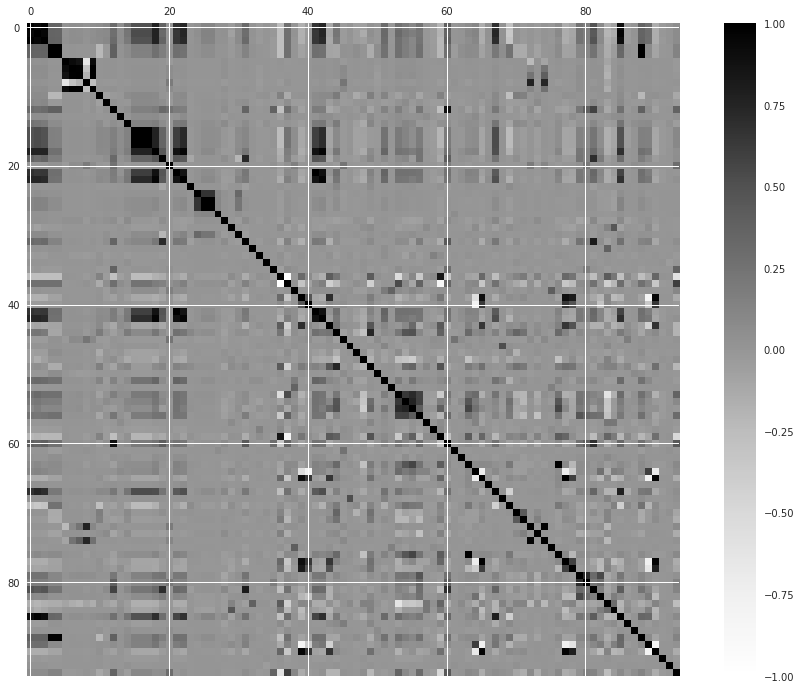

In [328]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_train_df.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [329]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [330]:
if notifyStatus: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.c) Training Data Balancing

In [331]:
# Perform SMOTE transformation on the training data (Block #1 of 2)
X_train_imbal = X_train_df.values
y_train_imbal = y_train_df.values.ravel()
print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

X_train_imbal.shape: (5455, 94) y_train_imbal.shape: (5455,)


In [332]:
# Perform SMOTE transformation on the training data (Block #2 of 2)
print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
over_sample = SMOTE(sampling_strategy=0.6, random_state=seedNum)
under_sample = RandomUnderSampler(sampling_strategy=1.0, random_state=seedNum)
steps = [('o', over_sample), ('u', under_sample)]
sample_pipeline = Pipeline(steps=steps)
X_train, y_train = sample_pipeline.fit_resample(X_train_imbal, y_train_imbal)
print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

Original class distribution - 1: 176 | 0: 5279
Resampled class distribution - 1: 3167 | 0: 3167


### 3.b) Feature Scaling and Data Pre-Processing

In [335]:
# Apply feature scaling and transformation
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
print(X_train)

[[0.49553941 0.55162451 0.54146368 ... 0.02682768 0.18143344 0.03854421]
 [0.46682592 0.5412669  0.52138765 ... 0.02679116 0.18111642 0.04600523]
 [0.45273729 0.50528783 0.50329247 ... 0.02664756 0.17962425 0.01636886]
 ...
 [0.44202411 0.36184023 0.47949136 ... 0.02845019 0.18403902 0.01345246]
 [0.46321196 0.52611533 0.51642126 ... 0.0260456  0.157876   0.01993529]
 [0.45050241 0.50218869 0.49937291 ... 0.02628865 0.16797748 0.02319015]]


### 3.d) Feature Selection

In [337]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [338]:
# # Finalize the training and validation datasets for the modeling activities
# X_train = X_train_df.to_numpy()
# y_train = y_train_df.ravel()
# # X_validation = X_validation_df.to_numpy()
# # y_validation = y_validation_df.ravel()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
# # print("X_validation.shape: {} y_validation.shape: {}".format(X_validation.shape, y_validation.shape))

X_train.shape: (6334, 94) y_train.shape: (6334,)


In [339]:
if notifyStatus: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [340]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [341]:
# Set up Algorithms Spot-Checking Array
startTimeTraining = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LGR', LogisticRegression(random_state=seedNum)))
train_models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=n_jobs)))
train_models.append(('BGT', BaggingClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('RNF', RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))

In [342]:
# Generate model in turn
for name, model in train_models:
	if notifyStatus: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_jobs, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if notifyStatus: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeTraining))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


LGR: 0.888498 (0.005165)
LogisticRegression(random_state=8)
Model training time: 0:00:02.732813 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    5.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


CART: 0.939110 (0.005368)
DecisionTreeClassifier(random_state=8)
Model training time: 0:00:05.147307 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KNN: 0.922980 (0.003498)
KNeighborsClassifier(n_jobs=2)
Model training time: 0:00:01.542204 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   13.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


BGT: 0.961956 (0.005093)
BaggingClassifier(n_jobs=2, random_state=8)
Model training time: 0:00:13.336277 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   11.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


RNF: 0.968615 (0.003558)
RandomForestClassifier(n_jobs=2, random_state=8)
Model training time: 0:00:11.676714 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


EXT: 0.973772 (0.002886)
ExtraTreesClassifier(n_jobs=2, random_state=8)
Model training time: 0:00:03.595290 

GBM: 0.951180 (0.003652)
GradientBoostingClassifier(random_state=8)
Model training time: 0:01:31.677321 

Average metrics (f1) from all models: 0.9437301370398289
Total training time for all models: 0:02:09.839120


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.5min finished


### 4.b) Spot-checking baseline algorithms

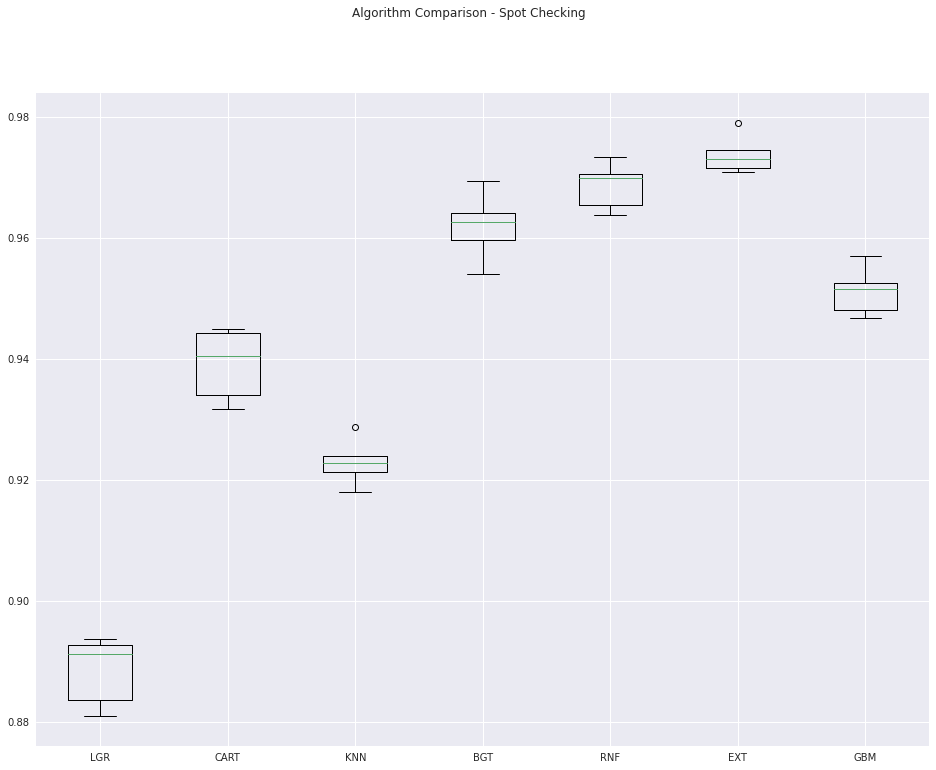

In [343]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [344]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Fine-tune and Improve Models

In [345]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Algorithm Tuning

In [346]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [347]:
# Tuning algorithm #1 - Extra Trees
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_model_names.append('EXT')
paramGrid1 = dict(n_estimators=np.array([100, 200, 300, 400, 500]))

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best: 0.973920 using {'n_estimators': 300}
0.973772 (0.002886) with: {'n_estimators': 100}
0.972869 (0.001241) with: {'n_estimators': 200}
0.973920 (0.001576) with: {'n_estimators': 300}
0.973188 (0.001819) with: {'n_estimators': 400}
0.972290 (0.002357) with: {'n_estimators': 500}
Model training time: 0:00:49.827060


In [348]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 300


In [349]:
# Tuning algorithm #2 - Random Forest
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_model_names.append('RNF')
paramGrid2 = dict(n_estimators=np.array([100, 200, 300, 400, 500]))

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best: 0.968615 using {'n_estimators': 100}
0.968615 (0.003558) with: {'n_estimators': 100}
0.968158 (0.002791) with: {'n_estimators': 200}
0.968165 (0.002685) with: {'n_estimators': 300}
0.968335 (0.001805) with: {'n_estimators': 400}
0.967725 (0.002097) with: {'n_estimators': 500}
Model training time: 0:02:38.505678


In [350]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 100


### 5.b) Compare Algorithms After Tuning

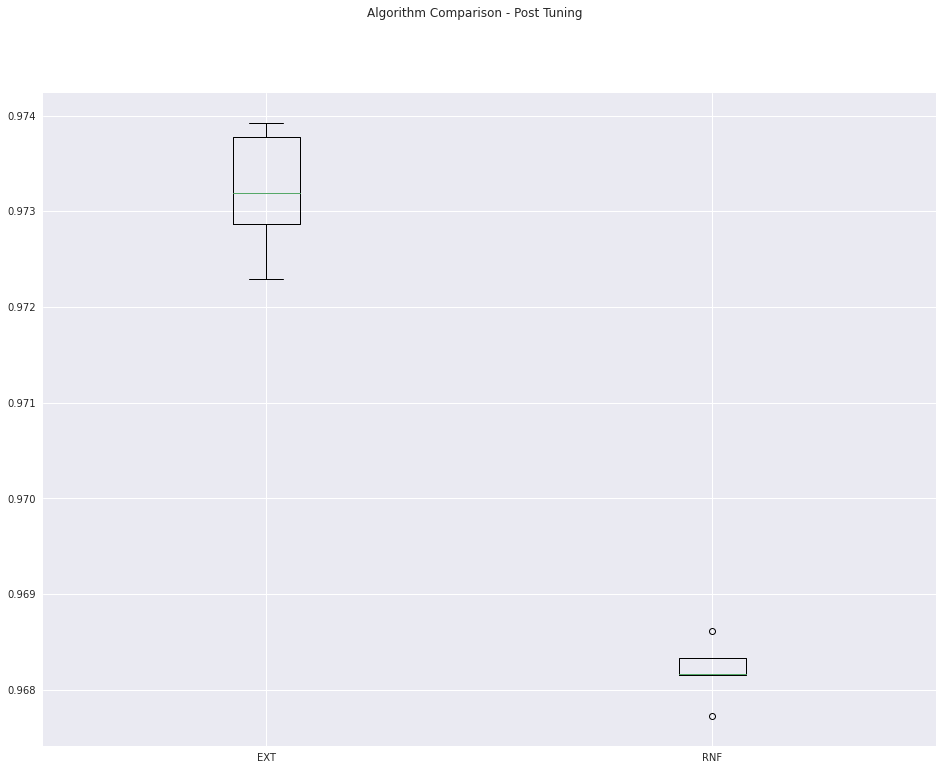

In [351]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [352]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 6 - Finalize Model and Present Analysis

In [353]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [354]:
# Train the final model
test_model = ExtraTreesClassifier(n_estimators=best_paramValue1, random_state=seedNum, n_jobs=n_jobs)
test_model.fit(X_train, y_train)
print(test_model)

ExtraTreesClassifier(n_estimators=300, n_jobs=2, random_state=8)


In [356]:
# Apply feature scaling and transformation to the test dataset
X_test = scaler.transform(X_test_df)
print(X_test)

[[0.4803783  0.53418011 0.52909685 ... 0.02679126 0.18111736 0.13682596]
 [0.59103983 0.63939163 0.62010814 ... 0.02680203 0.18121303 0.05649015]
 [0.52985911 0.58722198 0.57481664 ... 0.02680978 0.18128072 0.03131672]
 ...
 [0.50684932 0.57168556 0.55763156 ... 0.02681569 0.18133176 0.07088829]
 [0.4680934  0.52523986 0.51924621 ... 0.02643608 0.17631452 0.06648556]
 [0.53531907 0.59757959 0.5870764  ... 0.02683167 0.18146678 0.04122032]]


In [357]:
# Finalize the test dataset for the modeling testing
# X_test = X_test_df.to_numpy()
y_test = y_test_df.ravel()
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_test.shape: (1364, 94) y_test.shape: (1364,)


In [358]:
test_predictions = test_model.predict(X_test)
print('F1 Score:', f1_score(y_test, test_predictions))
print('ROC/AUC Score:', roc_auc_score(y_test, test_predictions))
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))

F1 Score: 0.5555555555555556
ROC/AUC Score: 0.8799242424242424
[[1273   47]
 [   9   35]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1320
           1       0.43      0.80      0.56        44

    accuracy                           0.96      1364
   macro avg       0.71      0.88      0.77      1364
weighted avg       0.97      0.96      0.96      1364



In [359]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [360]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:06:45.727378
